In [10]:
# Kütüphaneler import edilir.
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms,models
from torch.utils.data import random_split,TensorDataset,DataLoader
import numpy as np
import cv2,os,random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Mimarinin ve verilerin CPU yerine GPU'da eğitilmesi için cihaz seçimi yapılır.
print(device)

cuda


In [3]:
def resimleri_yukle(resim_klasörü):
    resimler = [] # Başlangıçta boş bir liste oluşturulur, bu liste tüm resimleri içerir ve return edilir.
    for resim_ismi in os.listdir(resim_klasörü): # Seçilen klasördeki her resmin ismi alınır.
        if resim_ismi.endswith((".jpg", ".png", ".jpeg")): # Eğer her bir resmin ismi uygun formatta ise işlem başlatılır.
            resim_yolu = os.path.join(resim_klasörü, resim_ismi) # Seçilen resmin tam adresi alınır (klasör yolu + resim adı).
            resim = cv2.imread(resim_yolu) # Resim BGR formatında okunur.
            resim = cv2.cvtColor(resim, cv2.COLOR_BGR2RGB) # BGR'dan RGB'ye dönüştürme işlemi yapılır.
            resim = cv2.resize(resim,(256,256)) # Her resim boyutlandırılır eğer resimlerin boyutları farklı olsaydı mimari hata verirdi.
            resim = resim / 255.0 # Her bir resim 0 ile 1 arasında olacak şekilde normalize edilir. Bir pikselin en küçük değeri 0 iken en büyük değeri 255'tir.
            resimler.append(resim.transpose(2, 0, 1)) # NumPy'da resmin formatı (W,H,C) iken PyTorch'da resmin formatı (C,W,H)'dır bu yüzden boyutların yeri değiştirilir.

    return np.array(resimler) # Tüm resimler bir NumPy array'i olacak şekilde return edilir.

In [4]:
high_resolution_images=resimleri_yukle("/content/high_resolution_images") # Yüksek çözünürlüklü resimler fonksyion yardımıyla alınır.
low_resolution_images=resimleri_yukle("/content/low_resolution_images") # Düşük çözünürlüklü resimler fonksiyon yardımıyla alınır.
low_images = torch.tensor(low_resolution_images, dtype=torch.float32) # NumPy formatındaki resimleri torch formatına çevrilir ve Float32 olarak hassasiyet ayarı seçilir.
high_images = torch.tensor(high_resolution_images, dtype=torch.float32) #NumPy formatındaki resimleri torch formatına çevrilir ve Float32 olarak hassasiyet ayarı seçilir.
dataset = TensorDataset(low_images, high_images) # Düşük ve yüksek çözünürlüklü görüntüler karşılıklı olacak şekilde eşleştirilir.

val_ratio = 0.03 # Verinin yüzde kaçı validation için ayrılacağı belirlenir.
val_size = int(len(dataset) * val_ratio) # Veri setinin kaç tane validation örneği içereceği hesaplanır.
train_size = len(dataset) - val_size  # Veri setinin kaç tane train örneği içereceği hesaplanır.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # Veri seti train ve validation olacak şekilde bölünür.

batch_size = 8 # Veri setinde mini-batch algoritmasına göre her batch'de ne kadar örnek veri olacağı seçilir.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Train veri seti batch'lere ayrılır ve her batch rastgele karıştırılır.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Validation veri seti batch'lere ayrılır ve hir bir batch karıştırılmaz çünkü gerek yoktur.

print(f"Train örnek sayısı: {len(train_dataset)}, Validation örnek sayısı: {len(val_dataset)}")

Train örnek sayısı: 467, Validation örnek sayısı: 14


In [5]:

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, oran=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // oran, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // oran, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x)) # Kanal sayısı değişmez ama pooling ortalamaya göre yapılır.
        max_out = self.fc(self.max_pool(x)) # Kanal sayısı değişmez ama pooling maximuma değere göre yapılır.
        return self.sigmoid(avg_out + max_out) * x # Sigmoid ile de hangi kanalların daha önemli olduğu 0 ile 1 arasında değişen olasılık değerleri ile hesaplanır.

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False) # Kanal sayısı özel olarak 2'dir çünkü ilk kanal ortalama ikinci kanal ise maksimuma göre uzlamsal bilgi çıkarır.
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out,max_out], dim=1) # 1 + 1 = 2 kanal
        return self.sigmoid(self.conv(out)) * x

class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=4, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self, x):
        x = self.channel_attention(x) # Sırasıyla Channel Attention ve Spatial Attention uygulanır.
        x = self.spatial_attention(x)
        return x

class DeepFusionNet(nn.Module): # nn.Module ile kalıtım yapılır.
    def __init__(self):
        super().__init__()
        self.relu = nn.PReLU() # Gizli katmanlarda aktivasyon fonksiyonu olarak Parametrik Relu tercih edilir.
        self.sigmoid = nn.Sigmoid() # Çıkış katmanında ise Sigmoid fonksiyonu tercih edilir.
        self.pool = nn.MaxPool2d(2,2) # Pooling ile autoencoder mimarisinde encoder kısmı için boyut azaltma tercih edilir.
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest") # Decoder da ise Upsample ile boyut arttırma işlemi tercih edilir.

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Klasik (3×3) kernel kullanılır ve padding=1 ile boyut korunur, stride değeri otomatik olarak 1'dir.
        self.conv1b = nn.Conv2d(128, 128, 3, padding=1)  # derinlik ekledik
        self.bn1 = nn.BatchNorm2d(128) # Aktivasyonlar ortalam ve standart sapmaya göre normalize edilecektir.
        self.cbam1 = CBAM(128) # Attention mekanizması için CBAM blokları kullanılır.
        self.conv1_depth = nn.Conv2d(32, 32, kernel_size=3, groups=32, padding=1) # Depthwise convolution eklenir ve her filtre kendi kanalı ile sadece işlem yapar.
        self.conv1_kernel = nn.Conv2d(3, 32, kernel_size=5, padding=2) # Inception blok için farklı kernel size eklenir ve boyut yine korunur.
        self.conv1_kernel_depth = nn.Conv2d(32, 32, kernel_size=5,groups=32, padding=2) # Depthwise convolution eklenir ve her filtre kendi kanalı ile sadece işlem yapar.

        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)

        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.cbam3 = CBAM(128)

        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.cbam4 = CBAM(128)

        # Bottleneck
        self.pointwise=nn.Conv2d(128,32,1) # Convolution blokları DenseNet mimarisinde olduğu gibi ard arda sıralanır.
        self.bottleneck = nn.Conv2d(32, 32, 3, padding=1)
        self.bottleneckb = nn.Conv2d(32, 32, 3, padding=1)
        self.bottleneckb2 = nn.Conv2d(32, 32, 3, padding=1)
        self.cbam_bottleneck = CBAM(128)
        self.bn_bottleneck=nn.BatchNorm2d(128)

        # Decoder
        self.dec1 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec1b = nn.Conv2d(128, 128, 3, padding=1)
        self.cbam_dec1 = CBAM(128)

        self.dec2 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec2b = nn.Conv2d(128, 128, 3, padding=1)
        self.cbam_dec2 = CBAM(128)

        self.dec3 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec3b = nn.Conv2d(128, 128, 3, padding=1)
        self.cbam_dec3 = CBAM(128)

        self.dec4 = nn.Conv2d(160, 64, 3, padding=1)
        self.dec4b = nn.Conv2d(64, 64, 3, padding=1)
        self.cbam_dec4 = CBAM(64)

        self.final_conv = nn.Conv2d(64,3,3,padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.relu(self.conv1(x)) #32 kanal (3×3) kernel size
        e1_depth=self.conv1_depth(e1) #32 kanal (3×3) kernel size
        e1_ghost=torch.cat([e1,e1_depth],dim=1)  # 32 + 32 = 64 kanal
        e1_kernel=self.relu(self.conv1_kernel(x)) #32 kanal (5×5) kernel size
        e1_kernel_depth=self.relu(self.conv1_kernel_depth(e1_kernel)) #32 kanal (5×5) kernel size
        e1_kernel_ghost=torch.cat([e1_kernel,e1_kernel_depth],dim=1) # 32+ 32 = 64 kanal
        e1_ghost_full=torch.cat([e1_ghost,e1_kernel_ghost],dim=1) # 64 + 64 = 128 kanal
        e11 = self.relu(self.conv1b(e1_ghost_full)) #128 kanal
        e11 = self.cbam1(self.bn1(e11)) #128 kanal
        p1 = self.pool(e11) #128 kanal

        e2 = self.relu(self.conv2(p1)) #128 kanal
        e2 = self.relu(self.conv2b(e2)) #128 kanal
        e2 = self.cbam2(self.bn2(e2)) #128 kanal
        p2 = self.pool(e2)  #128 kanal

        e3 = self.relu(self.conv3(p2)) #128 kanal
        e3 = self.relu(self.conv3b(e3)) #128 kanal
        e3 = self.cbam3(self.bn3(e3)) #128 kanal
        p3 = self.pool(e3)  #128 kanal

        e4 = self.relu(self.conv4(p3)) #128 kanal
        e4 = self.relu(self.conv4b(e4)) #128 kanal
        e4 = self.cbam4(self.bn4(e4)) #128 kanal
        p4 = self.pool(e4) #128 kanal

        # Bottleneck
        p4=self.pointwise(p4) #32 kanal
        p4_1 = self.relu(self.bottleneck(p4)) #32 kanal
        p4_2 = self.relu(self.bottleneckb(p4_1)) #32 kanal
        p4_3 = self.relu(self.bottleneckb(p4_2)) #32 kanal
        p4_4 = self.relu(self.bottleneckb(p4_3)) #32 kanal
        t = torch.cat([p4_1,p4_2,p4_3,p4_4], dim=1)# 32 + 32 + 32 + 32 = 128 kanal
        t_plus = self.relu(self.cbam_bottleneck(t)) #128 kanal
        b = self.cbam_bottleneck(t_plus) #128 kanal


        # Decoder
        d1 = self.upsample(b)
        d1 = torch.cat([d1,e4], dim=1) # 128 + 128 = 256 kanal
        d1 = self.relu(self.dec1(d1)) # 128 kanal
        d1 = self.relu(self.dec1b(d1)) # 128 kanal
        d1 = self.cbam_dec1(d1) #128 kanal

        d2 = self.upsample(d1)
        d2 = torch.cat([d2,e3], dim=1) # 128 + 128 = 256 kanal
        d2 = self.relu(self.dec2(d2)) # 128 kanal
        d2 = self.relu(self.dec2b(d2)) # 128 kanal
        d2 = self.cbam_dec2(d2) # 128 kanal

        d3 = self.upsample(d2)
        d3 = torch.cat([d3,e2], dim=1) # 128 + 128 = 256 kanal
        d3 = self.relu(self.dec3(d3)) # 128 kanal
        d3 = self.relu(self.dec3b(d3)) # 128 kanal
        d3 = self.cbam_dec3(d3) # 128 kanal

        d4 = self.upsample(d3)
        d4 = torch.cat([d4,e1], dim=1) # 128 + 32 = 160 kanal
        d4 = self.relu(self.dec4(d4)) # 64 kanal
        d4 = self.relu(self.dec4b(d4)) # 64 kanal
        d4 = self.cbam_dec4(d4) # 64 kanal

        out = self.sigmoid(self.final_conv(d4)) # 3 kanal
        return out

In [6]:
def ssim_loss(img1, img2, window_size=11, size_average=True):
    C1 = 0.01 ** 2 # Standart sabitler SSIM formülüne göre.
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, window_size, 1, window_size//2) # Boyut değişimi olmaz
    mu2 = F.avg_pool2d(img2, window_size, 1, window_size//2)  # Boyut değişimi olmaz

    sigma1 = F.avg_pool2d(img1 * img1, window_size, 1, window_size//2) - mu1.pow(2)
    sigma2 = F.avg_pool2d(img2 * img2, window_size, 1, window_size//2) - mu2.pow(2)
    sigma12 = F.avg_pool2d(img1 * img2, window_size, 1, window_size//2) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1.pow(2) + mu2.pow(2) + C1) * (sigma1 + sigma2 + C2))

    if size_average:
        return ssim_map.mean()
    else:
        pass

# Hibrit Loss MSE + SSIM
class MSE_SSIM_Loss(nn.Module):
    def __init__(self, alpha=0.84):
        super(MSE_SSIM_Loss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha  # ağırlık katsayısı

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        ssim_val = ssim_loss(pred, target)
        # SSIM yüksek olsun istiyoruz, o yüzden (1 - ssim)
        return self.alpha * mse_loss + (1 - self.alpha) * (1 - ssim_val)



In [9]:

model = DeepFusionNet().to(device) # Mimari tanımlanır ve GPU'ya aktarılır.


criterion = MSE_SSIM_Loss(0.1) # %10 MSE ve %90 SSIM skoru baz alınması için parametre seçilir.
optimizer = Adam(model.parameters(), lr=0.001) # Adam optimizer kullanılır (momentumdan dolayı).

epochs = 400 # İterasyon sayısı belirlenir.
train_loss_list, val_loss_list = [], []
train_loss_list_ssim, val_loss_list_ssim = [], []

for epoch in range(epochs):
    model.train() # Eğitim moduna geçilir.
    total_loss = total_ssim= 0.0

    for low, high in train_loader:
        low, high = low.to(device), high.to(device) # VEriler GPU'ya aktarılır.

        optimizer.zero_grad() # Birikmiş gradyanlar sıfırlanır.
        outputs = model(low) # Tahminler alınır.

        loss = criterion(outputs, high) # Hata hesaplanır
        loss.backward() # Gradyanlar hesaplanır.
        optimizer.step() # Ağırlıklar hesaplanan gradyanlara göre güncellenir.

        total_loss += loss.item()
        total_ssim+= ssim_loss(outputs, high).item()* 100

    train_loss_list.append(total_loss / len(train_loader))
    train_loss_list_ssim.append(total_ssim/len(train_loader))

    model.eval() # Model test moduna alınır.
    val_total_ssim= val_total_loss= 0.0

    with torch.no_grad(): # Gradyan hesaplanması geçici olarak kapatılır.
        for val_low, val_high in val_loader:
            val_low, val_high = val_low.to(device), val_high.to(device) # Veriler GPU'ya aktarılır.

            val_outputs = model(val_low) # Tahmin yapılır.
            val_loss = criterion(val_outputs, val_high) # Hata hesaplanır
            val_total_loss += val_loss.item()
            val_total_ssim+= ssim_loss(val_outputs, val_high).item() * 100
    val_loss_list.append(val_total_loss / len(val_loader))
    val_loss_list_ssim.append(val_total_ssim/len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | " f"Train Loss: {train_loss_list[-1]:.4f} | Val Loss: {val_loss_list[-1]:.4f} | "f"Train SSIM: %{train_loss_list_ssim[-1]:.2f} | Val SSIM: %{val_loss_list_ssim[-1]:.2f}")




Epoch 1/400 | Train Loss: 0.2702 | Val Loss: 0.2423 | Train SSIM: %70.29 | Val SSIM: %73.35
Epoch 2/400 | Train Loss: 0.1929 | Val Loss: 0.2033 | Train SSIM: %78.79 | Val SSIM: %77.63
Epoch 3/400 | Train Loss: 0.1715 | Val Loss: 0.1759 | Train SSIM: %81.15 | Val SSIM: %80.64
Epoch 4/400 | Train Loss: 0.1531 | Val Loss: 0.1544 | Train SSIM: %83.17 | Val SSIM: %82.99
Epoch 5/400 | Train Loss: 0.1396 | Val Loss: 0.1548 | Train SSIM: %84.65 | Val SSIM: %82.93
Epoch 6/400 | Train Loss: 0.1365 | Val Loss: 0.1320 | Train SSIM: %84.99 | Val SSIM: %85.52
Epoch 7/400 | Train Loss: 0.1261 | Val Loss: 0.1344 | Train SSIM: %86.14 | Val SSIM: %85.22
Epoch 8/400 | Train Loss: 0.1274 | Val Loss: 0.1304 | Train SSIM: %86.00 | Val SSIM: %85.68
Epoch 9/400 | Train Loss: 0.1186 | Val Loss: 0.1170 | Train SSIM: %86.95 | Val SSIM: %87.13
Epoch 10/400 | Train Loss: 0.1175 | Val Loss: 0.1268 | Train SSIM: %87.07 | Val SSIM: %86.08
Epoch 11/400 | Train Loss: 0.1138 | Val Loss: 0.1129 | Train SSIM: %87.48 | Val

KeyboardInterrupt: 

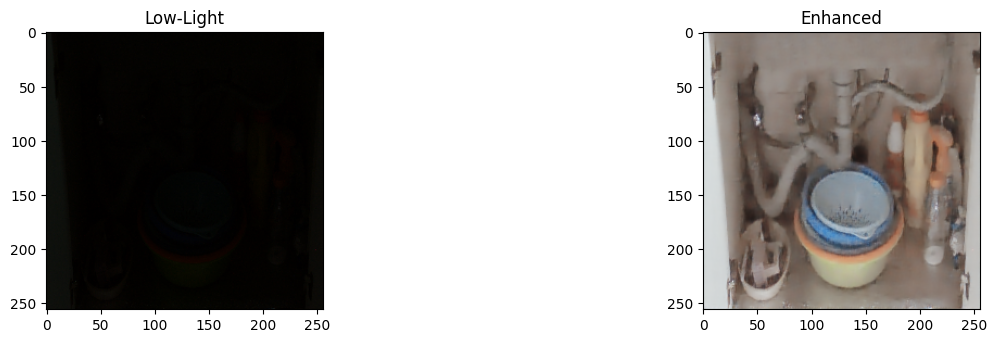

In [11]:
model.eval()
test_low = cv2.imread("/content/test.png")  # BGR olarak oku
test_low = cv2.cvtColor(test_low, cv2.COLOR_BGR2RGB)  # RGB'ye çevir
test_low = cv2.resize(test_low, (256, 256))
test_low = test_low / 255.0  # Normalize (0-1 arası)
test_low = torch.tensor(test_low, dtype=torch.float32)# Tensor'a çevir
test_low = test_low.permute(2, 0, 1).unsqueeze(0).to(device)  # (C,H,W) + PyTorch içib batch (1) ekle
with torch.no_grad(): # Gradyan hesaplamayı kapat.
    enhanced = model(test_low).cpu().squeeze().permute(1, 2, 0).numpy() # Çıkarım sonucu oluşan görüntüyü CPU'ya aktar ve boyutları değişitr NumPy ve Matplotlib için.
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_low.cpu().squeeze().permute(1, 2, 0).numpy())
plt.title("Low-Light")
plt.subplot(1, 3, 3)
plt.imshow(enhanced)
plt.title("Enhanced")
plt.tight_layout()
plt.show()

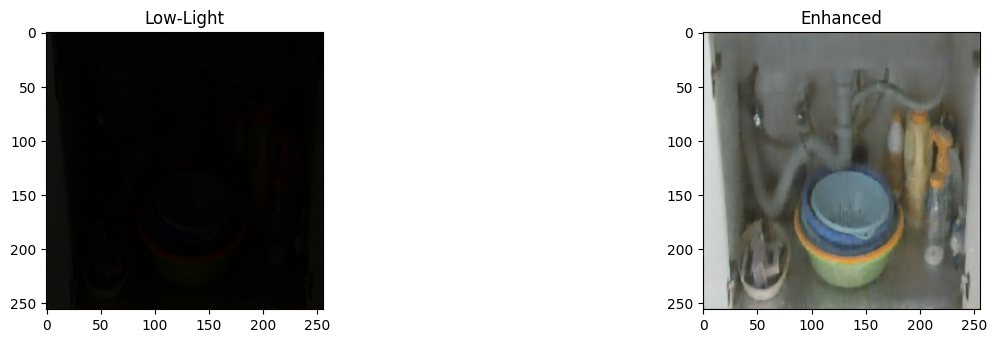

In [14]:
model.load_state_dict(torch.load("/content/model.pth", map_location=device)) # Ya da direk eğitilmiş model de kullanılabilir.
model.eval()
test_low = cv2.imread("/content/test.png")  # BGR olarak oku
test_low = cv2.cvtColor(test_low, cv2.COLOR_BGR2RGB)  # RGB'ye çevir
test_low = cv2.resize(test_low, (256, 256))
test_low = test_low / 255.0  # Normalize (0-1 arası)
test_low = torch.tensor(test_low, dtype=torch.float32)# Tensor'a çevir
test_low = test_low.permute(2, 0, 1).unsqueeze(0).to(device)  # (C,H,W) + PyTorch içib batch (1) ekle
with torch.no_grad(): # Gradyan hesaplamayı kapat.
    enhanced = model(test_low).cpu().squeeze().permute(1, 2, 0).numpy() # Çıkarım sonucu oluşan görüntüyü CPU'ya aktar ve boyutları değişitr NumPy ve Matplotlib için.
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_low.cpu().squeeze().permute(1, 2, 0).numpy())
plt.title("Low-Light")
plt.subplot(1, 3, 3)
plt.imshow(enhanced)
plt.title("Enhanced")
plt.tight_layout()
plt.show()